Урок 5. Рекуррентные нейронные сети
---

**Домашнее задание**:
Используя файл Web5.ipynb (он в полезных ссылках):

Попробуйте обучить нейронную сеть RNN/LSTM/GRU на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний).

Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data_path = '../../data/prod_data/prod_data.xlsx'
df = pd.read_excel(data_path, sheet_name='prod')

In [4]:
df

,Date,Well,Formation,Lift type,"Choke, mm","THP, MPa","Oil production, m3","Oil production (actual), t","Water production, m3","Water production, t",...,"Oil density, t/m3","Water density, t/m3",Working hours,Downtime hours,"Oil production (plan) daily, t/d","Oil production (plan), t",Workover,Field,Longitude,Latitude
0,1996-05-01,Plat-2,Evlanov-Livenskian,Natural flow,NaN,NaN,1549.516908,1283.0,0.000000e+00,0.000,...,0.828,1.164,336.0,408.0,NaN,NaN,NaN,Pamyatno-Sasovskoe,45.173402,50.798989
1,1996-06-01,Plat-2,Evlanov-Livenskian,Natural flow,NaN,NaN,4330.917874,3586.0,0.000000e+00,0.000,...,0.828,1.164,696.0,24.0,NaN,NaN,NaN,Pamyatno-Sasovskoe,45.173402,50.798989
2,1996-07-01,Plat-2,Evlanov-Livenskian,Natural flow,NaN,NaN,5179.951691,4289.0,0.000000e+00,0.000,...,0.828,1.164,744.0,0.0,NaN,NaN,NaN,Pamyatno-Sasovskoe,45.173402,50.798989
3,1996-08-01,Plat-2,Evlanov-Livenskian,Natural flow,NaN,NaN,5056.763285,4187.0,0.000000e+00,0.000,...,0.828,1.164,744.0,0.0,NaN,NaN,NaN,Pamyatno-Sasovskoe,45.173402,50.798989
4,1996-09-01,Plat-2,Evlanov-Livenskian,Natural flow,NaN,NaN,5208.937198,4313.0,0.000000e+00,0.000,...,0.828,1.164,720.0,0.0,NaN,NaN,NaN,Pamyatno-Sasovskoe,45.173402,50.798989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6223,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6224,NaT,NaN,NaN,NaN,NaN,NaN,NaN,10648339.0,2.898988e+06,3332110.564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6225,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6226,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.shape

(6228, 22)

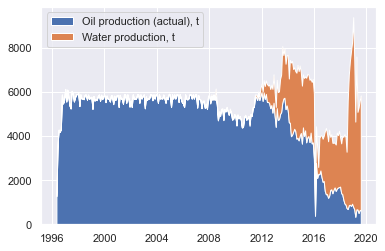

In [30]:
# set seaborn style
#sns.set_theme()
 
# Data
x = df['Date'][:280]
y = df['Oil production (actual), t'][:280].to_numpy(), \
    df['Water production, t'][:280].to_numpy()

# Plot
plt.stackplot(x,y, labels=['Oil production (actual), t', 'Water production, t'])
plt.legend(loc='upper left')
plt.show()